In agronomy, environmental science, and hydrology, the assessment of models, sensors, and  measurement methodologies is typically achieved by comparing them against a more accurate benchmark or observed data using several error metrics. 

To illustrate the computation of different error metrics we will use a dataset obtained from the calibration of an actual soil moisture sensor in laboratory conditions. In this case, the sensor provides an estimate of soil moisture and the soil moisture values obtained using the thermo-gravimetric method (i.e. oven-drying the soil samples) provide the benchmark or ground-truth values.


In [51]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [52]:
# Load dataset
df = pd.read_csv('../datasets/hydrosense_lab_calibration.csv', skiprows=[0])
df.head(3)


,measurement,sand,clay,textural_class,bulk_density,vwc_true,period_average,vwc_sensor
0,1,16,33,silty clay loam,1.44,4.6,1.120,2.1
1,2,16,33,silty clay loam,1.32,12.5,1.255,8.8
2,3,16,33,silty clay loam,1.40,23.5,1.550,27.0


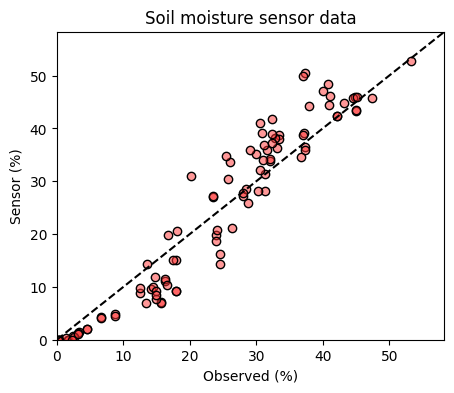

In [53]:
# Dataset
y_obs = df['vwc_true']
y_pred = df['vwc_sensor']

# Find largest value to avoid hard coding
max_val = np.concatenate((obs,pred)).max() + 5

# Plot data
plt.figure(figsize=(5,4))
plt.title('Soil moisture sensor data')
plt.scatter(y_obs, y_pred, facecolor=(1,0.2,0.2,0.5), edgecolor='k')
plt.plot([0,max_val], [0,max_val], linestyle='--', color='k', label='1:1 line')
plt.xlabel('Observed (%)')
plt.ylabel('Sensor (%)')
plt.xlim([0, max_val])
plt.ylim([0, max_val])
plt.show()


## Residuals

The residuals are the differences between the observed values and the predicted values. Residuals are a diagnostic measure to understand whether the model or a sensor has systematically overestimated or underestimated the benchmark data. Analyzing the pattern of residuals can reveal biases in the model or indicate whether certain assumptions of the model are not being met.

In [54]:
residuals =  y_pred - y_obs
print(residuals)

0    -2.5
1    -3.7
2     3.5
3     5.4
4     0.2
     ... 
93   -2.1
94    1.9
95    1.7
96    7.1
97    5.1
Length: 98, dtype: float64


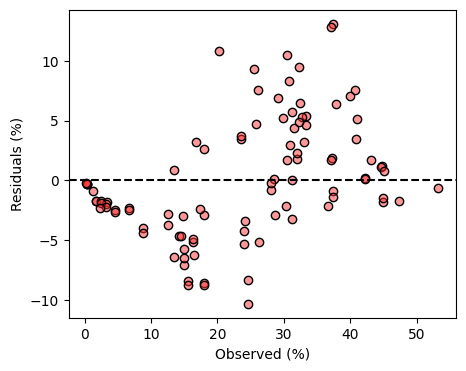

In [55]:
# Visually inspect residuals
plt.figure(figsize=(5,4))
plt.scatter(y_obs, residuals, facecolor=(1,0.2,0.2,0.5), edgecolor='k')
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Observed (%)')
plt.ylabel('Residuals (%)')
plt.show()

Inspection of the residuals revealed that at low soil moisture levels the sensor tends to underestimate soil moisture and that at high soil moisture levels the sensor tends to overestimate soil moisture.

## Mean bias error (MBE)

The MBE determines the average bias, showing whether the model, sensor, or measurement consistently overestimates or underestimates compared to the benchmark. In the case of the MBE, **positive** values mean over-prediction and **negative** values under-prediction. Although this would depend on the order of the subtraction when computing the residuals.

A bias equal to zero can be a consequence of small errors or very large errors balanced by opposite sign. It is always recommended to include other error metrics in addition to the mean bias error.

In [56]:
mbe = np.nanmean(residuals)
print(mbe)

0.0836734693877551


## Sum of residuals (SRES)

In [57]:
# Sum of residuals
sres = np.nansum(residuals)
print(sres)

8.200000000000001


## Sum of the absolute of residuals (SARES)

In [58]:
# Sum of absolute residuals
sares = np.nansum(np.abs(residuals))
print(sares)

391.6


## Sum of squared errors (or residuals)

In [59]:
# Sum of squared errors
sse = np.nansum(residuals**2)
print(sse)

2459.6400000000003


## Mean squared error (MSE)

In [60]:
# Mean squared error
mse = np.nanmean(residuals**2)
print(mse)

25.09836734693878


## Root mean squared error (RMSE)

The RMSE is one of the most popular error metrics in modeling studies and quantifies the square root of the average of squared differences between the predicted or measured values and the benchmark. It emphasizes larger errors, making it useful for understanding substantial discrepancies, but this feature also makes it very sensitive to outliers.

When comparing two estimates where none of them represents the ground truth it is better to name this error metric the "Root Mean Squared Difference" to emphasize that is the difference between two estimates. The word "error" is typically reserved to represent deviations against  a gold standard or ground-truth value.


In [61]:
# Root mean squared error
rmse = np.sqrt(np.nanmean(residuals**2))
print(rmse)

5.009827077548564


## Relative root mean squared error (RRMSE)

The RRMSE is more meaningful than the RMSE when comparing errors from datasets with different units or ranges. Sometimes the RRMSE is computed by dividing the RMSE over the range of the observed values rather than the average of the observed values.


In [62]:
# Realtive root mean squared error
rrmse = np.sqrt(np.nanmean(residuals**2)) / np.nanmean(y_obs)
print(rrmse)

0.20987605420414623


## Mean absolute error (MAE)

The MAE measures the average magnitude of the absolute errors between the predictions or measurements and the benchmark, treating all deviations equally without regard to direction. As a result, the MAE is a more robust error metric against outliers compared to the RMSE.


In [63]:
mae = np.nanmean(np.abs(residuals))
print(mae)

3.995918367346939


## Median absolute error

The MedAE calculates the median of the absolute differences between the benchmark values and the predictions, providing a measure of the typical error size. The use of the median gives the MedAE an advantage over the mean since it is less sensitive to outliers.

In [64]:
# Median absolute error
medae = np.nanmedian(np.abs(residuals))
print(medae)

3.1999999999999975


## Willmott index of agreement (D)

This index offers a normalized measure, ranging from 0 (no agreement) to 1 (perfect agreement, `y_obs=y_pred`, and consequently `SSE=0`), evaluating the relative error between the predicted/measured values and the benchmark. It is particularly useful for addressing the limitations of other statistical measures. 

In [65]:
abs_diff_pred = np.abs(y_pred - np.nanmean(y_obs))
abs_diff_obs  = np.abs(y_obs  - np.nanmean(y_obs))

willmott = 1 - np.nansum(residuals**2) / np.nansum((abs_diff_pred + abs_diff_obs)**2)
print(willmott)


0.9717700524449996


## Nash-Sutcliffe Efficiency

The NSE assesses the predictive power of models or measurements by comparing the variance of the residuals to the variance of the observed data. An NSE of 1 suggests an excellent match, while values below 0 imply that the average of the observed data is a better predictor than the model or measurement under scrutiny.

In [66]:
# Nash-Sutcliffe Efficiency

numerator = np.sum(residuals**2)
denominator = np.sum((y_obs - np.mean(y_obs))**2)
nse = 1 - numerator/denominator
print(nse)

0.8653258914122538


## References

Willmott, C.J., Robeson, S.M. and Matsuura, K., 2012. A refined index of model performance. International Journal of Climatology, 32(13), pp.2088-2094.

Willmott, C.J. and Matsuura, K., 2005. Advantages of the mean absolute error (MAE) over the root mean square error (RMSE) in assessing average model performance. Climate research, 30(1), pp.79-82.

Willmott, C.J., 1981. On the validation of models. Physical geography, 2(2), pp.184-194.